In [1]:
import sympy as sp
from sympy import latex
from sympy.physics.mechanics import dynamicsymbols

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import copernicusmarine
from scipy.integrate import cumulative_trapezoid as cumtrapz

import xarray as xr

In [2]:
t = dynamicsymbols._t


x, y, z, theta, phi = dynamicsymbols("x y z theta phi")  # x and y -> buoy coordinates

m_b, m_d, l, g = sp.symbols(
    "m_b m_d l g", positive=True
)  # mass buoy, mass drogue in [kg], wire length in [m], g in [m(s^2)]

k_b, k_d = sp.symbols("k_b k_d", positive=True)  # drag coefficients for buoy and drogue

U_b, V_b, U_d, V_d = sp.symbols(
    "U_b V_b U_d V_d", real=True
)  # surface horizontal velocities

# U_0, V_0 = sp.symbols('U_0 V_0', real = True) # surface horizontal velocities

In [3]:
lon0, lat0 = 54.6, 10.5  # largest variance of shear between 0 and 3m depth

time0 = np.datetime64("2009-04-08T23:58:00")

In [4]:
def convert_to_lonlat(y_in_m, x_in_m, lon0=lon0, lat0=lat0):
    deg_per_meter_lon = (
        1 / 111000 / np.cos(np.deg2rad(lat0))
    )  # stole this from our pherwiss project
    deg_per_meter_lat = 1 / 111000

    lon = lon0 + x_in_m * deg_per_meter_lon
    lat = lat0 + y_in_m * deg_per_meter_lat

    return lon, lat

The buoy is fixed to the water surface and initially has no possibility of lifting off or being pushed/pulled underwater (z = 0). The position of the drogue is described in spherical coordinates depending on the position of the buoy.

In [5]:
r_b = sp.Matrix([x, y, 0])  # buoy position

r = l * sp.Matrix(
    [
        sp.sin(theta) * sp.cos(phi),
        sp.sin(theta) * sp.sin(phi),
        sp.cos(theta),
    ]
)

r_d = r_b + r  # drogue position

display(r_d)

Matrix([
[l*sin(theta(t))*cos(phi(t)) + x(t)],
[l*sin(phi(t))*sin(theta(t)) + y(t)],
[                   l*cos(theta(t))]])

u_b and u_d represent the flow velocities at the water surface and at the height of the drogue. Later, the flow velocity below the water surface will be implemented as a function of z.

In [6]:
# velocities

v_b = r_b.diff(t)
v_d = r_d.diff(t)

u_b = sp.Matrix([U_b, V_b, 0])
u_d = sp.Matrix([U_d, V_d, 0])

F_b and F_d describe the drag forces on the buoy and the drogue.

In [7]:
def _mag(vec):
    return sp.sqrt(vec.dot(vec))


F_b = -k_b * _mag(v_b - u_b) * (v_b - u_b)  # drag buoy with ext. velocity
F_d = -k_d * _mag(v_d - u_d) * (v_d - u_d)  # drag drogue with ext. velocity

In [8]:
# lagrangian

T = sp.Rational(1, 2) * m_b * v_b.dot(v_b) + sp.Rational(1, 2) * m_d * v_d.dot(
    v_d
)  # kinetic energy

V = m_d * g * r_d[2]  # potential energy

L = T - V  # lagrangian

Defining $q$, $\dot{q}$ and $\ddot{q}$

In [9]:
q = sp.Matrix([x, y, theta, phi])
qd = q.diff(t)
qdd = qd.diff(t)

Generalized forces: $\left(\begin{array}{c}
        \frac{\partial r}{\partial \theta} \cdot F \\
        \frac{\partial r}{\partial \phi} \cdot F
        \end{array}\right)$

In [10]:
Q = sp.Matrix([r_b.diff(qi).dot(F_b) + r_d.diff(qi).dot(F_d) for qi in q])

Q = sp.simplify(Q)

Equations of motion:    

$\frac{\partial}{\partial t} (\frac{\partial L}{\partial \dot{q}_j}) - \frac{\partial L}{\partial q_j} - Q_j = 0$

In [11]:
eoms = sp.Matrix(
    [L.diff(qdj).diff(t) - L.diff(qj) - Qj for qj, qdj, Qj in zip(q, qd, Q)]
)
eoms = sp.simplify(eoms)

In [12]:
M, F = sp.linear_eq_to_matrix(eoms, list(qdd))

In [13]:
M.shape, F.shape, qdd.shape

((4, 4), (4, 1), (4, 1))

In [14]:
par_syms = (m_b, m_d, l, g, k_b, k_d)

In [15]:
M_func = sp.lambdify(
    (t, x, y, theta, phi, *qd, m_b, m_d, l, g, k_b, k_d, U_b, V_b, U_d, V_d),
    M,
    modules="numpy",
)
F_func = sp.lambdify(
    (t, x, y, theta, phi, *qd, m_b, m_d, l, g, k_b, k_d, U_b, V_b, U_d, V_d),
    F,
    modules="numpy",
)

In [16]:
r_b_ = sp.lambdify((t,) + tuple(q) + tuple(qd) + par_syms + (U_b, V_b, U_d, V_d), r_b)
r_d_ = sp.lambdify((t,) + tuple(q) + tuple(qd) + par_syms + (U_b, V_b, U_d, V_d), r_d)

M_ = sp.lambdify((t,) + tuple(q) + tuple(qd) + par_syms, M)
F_ = sp.lambdify((t,) + tuple(q) + tuple(qd) + par_syms, F)

In [17]:
par_dict = {m_b: 0.5, m_d: 0.5, l: 3.0, g: 9.81, k_b: 0.5, k_d: 2.0}
par_vals = tuple(par_dict[k] for k in par_syms)

In [20]:
ds = copernicusmarine.open_dataset(
    dataset_id="cmems_mod_bal_phy_my_P1D-m",  # found via "Data Access" in the dataset view https://data.marine.copernicus.eu/product/BALTICSEA_MULTIYEAR_PHY_003_011/description
    service="arco-time-series",
)

ds_subset = ds.sel(time="2009-04", longitude=slice(9, 11), latitude=slice(54, 55))
ds_subset = ds_subset[["uo", "vo"]]
ds_subset = ds_subset.load()
ds_subset
# ds = xr.open_dataset("01_baltic_sea_particle_drift_flow.nc")
# ds

INFO - 2025-12-12T08:47:07Z - Selected dataset version: "202303"
INFO - 2025-12-12T08:47:07Z - Selected dataset part: "default"


<xarray.Dataset> Size: 57MB
Dimensions:    (time: 30, depth: 56, latitude: 60, longitude: 71)
Coordinates:
  * time       (time) datetime64[ns] 240B 2009-04-01 2009-04-02 ... 2009-04-30
  * depth      (depth) float32 224B 0.5016 1.516 2.548 ... 663.9 688.0 712.0
  * latitude   (latitude) float32 240B 54.01 54.02 54.04 ... 54.96 54.97 54.99
  * longitude  (longitude) float32 284B 9.042 9.069 9.097 ... 10.93 10.96 10.99
Data variables:
    uo         (time, depth, latitude, longitude) float32 29MB nan nan ... nan
    vo         (time, depth, latitude, longitude) float32 29MB nan nan ... nan
Attributes:
    source:       CMEMS BAL MFC NEMO model output converted to NetCDF
    title:        CMEMS NEMO daily integrated model fields
    comment:      Data on cropped native product grid. Horizontal velocities ...
    contact:      servicedesk.cmems@mercator-ocean.eu
    references:   https://marine.copernicus.eu/
    institution:  Baltic MFC, PU Danish Meteorological Institute
    Conventions:  CF-1.0

In [21]:
def get_uv(
    t, z_d, y, x, ds
):  # sadly I couldn't figure ot how to do this without loading the dataset four times.
    """Get horizontal currents at and drogue and buoy level."""

    time = time0 + t * np.timedelta64(1000, "ms")

    lon, lat = convert_to_lonlat(y_in_m=y, x_in_m=x)
    # not shown: conversion of (x,y) --> (lon,lat)

    # TODO: Note that this will load separately four times.
    # better: get ds_water_colum_at_time = ds.sel(time=..., latitude=..., longitude=...).load()
    # and then select U_b etc from there justing with depth=...

    U_b = (
        ds.sel(
            time=time,
            depth=0,
            latitude=lat,
            longitude=lon,
            method="nearest",
        )
        .uo.load()
        .data[()]
    )
    # load actually gets the data, .data[()] converts singleton xarray object to single number

    U_d = (
        ds.sel(
            time=time,
            depth=-z_d,
            latitude=lat,
            longitude=lon,
            method="nearest",
        )
        .uo.load()
        .data[()]
    )

    V_b = (
        ds.sel(
            time=time,
            depth=0,
            latitude=lat,
            longitude=lon,
            method="nearest",
        )
        .vo.load()
        .data[()]
    )

    V_d = (
        ds.sel(
            time=time,
            depth=-z_d,
            latitude=lat,
            longitude=lon,
            method="nearest",
        )
        .vo.load()
        .data[()]
    )

    return U_b, V_b, U_d, V_d

In [22]:
def rhs(t_num, y, parameter_values=par_vals):

    q_num = y[:4]
    qd_num = y[4:]

    th = q_num[2]
    length = parameter_values[2]

    x_b, y_b, th, ph = q_num

    z_d = float(max(0.0, length * np.cos(th)))

    U_b, V_b, U_d, V_d = get_uv(t_num, z_d, y_b, x_b, ds_subset)

    dyn_params = (*parameter_values, U_b, V_b, U_d, V_d)

    M_num = np.array(M_func(t_num, *q_num, *qd_num, *dyn_params), dtype=float)
    F_num = np.array(F_func(t_num, *q_num, *qd_num, *dyn_params), dtype=float).reshape(
        -1
    )

    qdd_num = np.linalg.solve(M_num, F_num)

    return np.concatenate([qd_num, qdd_num])

In [23]:
q0 = np.array([0.0, 0.0, 3 * np.pi / 4, 0.0])  # x, y, theta, phi
qd0 = np.array([0.0, 0.0, 0.0, 0.0])
y0 = np.concatenate([q0, qd0])

t_span = (0.0, 600.0)
t_eval = np.arange(t_span[0], t_span[1], 5.0)

In [24]:
sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, atol=1e-3, rtol=1e-3, method="RK23")
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.000e+00 ...  5.900e+02  5.950e+02]
        y: [[ 0.000e+00  1.360e+00 ... -3.968e+01 -4.003e+01]
            [ 0.000e+00 -1.164e-01 ... -1.534e+01 -1.547e+01]
            ...
            [ 0.000e+00  1.331e-01 ...  2.592e-03 -3.947e-03]
            [ 0.000e+00 -6.452e-01 ... -4.566e-04 -3.701e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 122903
     njev: 0
      nlu: 0

In [25]:
t = sol.t
x_p0 = float(sol.y[0, 0])
y_p0 = float(sol.y[1, 0])

U_series = []
V_series = []
for i in range(len(t)):
    x_i = float(sol.y[0, i])
    y_i = float(sol.y[1, i])
    U_b, V_b, _, _ = get_uv(t[i], 0.0, y_i, x_i, ds_subset)
    U_series.append(float(U_b))
    V_series.append(float(V_b))

U_series = np.asarray(U_series)
V_series = np.asarray(V_series)

x_p = x_p0 + np.concatenate(([0.0], cumtrapz(U_series, t)))
y_p = y_p0 + np.concatenate(([0.0], cumtrapz(V_series, t)))
z_p = np.zeros_like(t)

(np.float64(-16.243716387677512),
 np.float64(0.7735103041751197),
 np.float64(-3.1499999975088295),
 np.float64(0.14999999988137283))

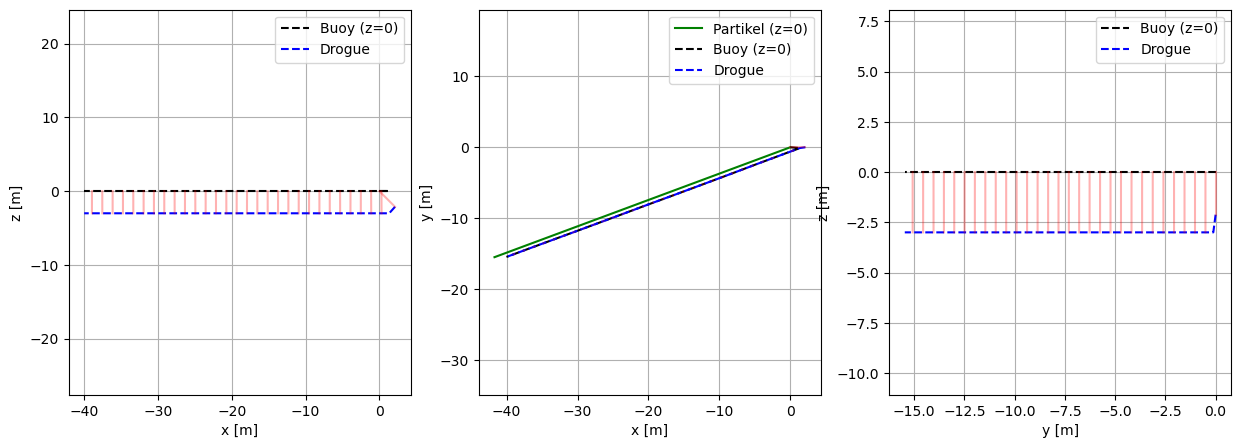

In [26]:
# x-z

r_b_traj_proj = []
r_d_traj_proj = []
for i, ti in enumerate(sol.t):

    q_num = sol.y[:4]
    qd_num = sol.y[4:]

    th = float(sol.y[2, i])
    length = par_vals[2]

    x_b = float(sol.y[0, i])
    y_b = float(sol.y[1, i])
    th = float(sol.y[2, i])
    lon, lat = convert_to_lonlat(x_b, y_b)
    z_d = float(max(0.0, par_vals[2] * np.cos(th)))

    U_b, V_b, U_d, V_d = get_uv(ti, z_d, y_b, x_b, ds_subset)

    rb = np.array(
        r_b_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals, U_b, V_b, U_d, V_d)),
        dtype=float,
    ).reshape(-1)
    rd = np.array(
        r_d_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals, U_b, V_b, U_d, V_d)),
        dtype=float,
    ).reshape(-1)
    r_b_traj_proj.append([rb[0], rb[2]])
    r_d_traj_proj.append([rd[0], rd[2]])

r_b_traj_proj = np.array(r_b_traj_proj)
r_d_traj_proj = np.array(r_d_traj_proj)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(r_b_traj_proj[:, 0], r_b_traj_proj[:, 1], "k--", label="Buoy (z=0)")
ax1.plot(r_d_traj_proj[:, 0], r_d_traj_proj[:, 1], "b--", label="Drogue")

step = max(1, len(sol.t) // 30)
for i in range(0, len(sol.t), step):
    ax1.plot(
        [r_b_traj_proj[i, 0], r_d_traj_proj[i, 0]],
        [r_b_traj_proj[i, 1], r_d_traj_proj[i, 1]],
        color="red",
        alpha=0.3,
    )

x_min = min(r_b_traj_proj[:, 0].min(), r_d_traj_proj[:, 0].min())
x_max = max(r_b_traj_proj[:, 0].max(), r_d_traj_proj[:, 0].max())

ax1.set_xlabel("x [m]")
ax1.set_ylabel("z [m]")
ax1.grid(True)
ax1.legend()
ax1.axis("equal")

# -------------------------------------------------------------------------------------------------------

# x-y

r_b_traj_proj = []
r_d_traj_proj = []
for i, ti in enumerate(sol.t):

    q_num = sol.y[:4]
    qd_num = sol.y[4:]

    th = float(sol.y[2, i])
    length = par_vals[2]

    x_b = float(sol.y[0, i])
    y_b = float(sol.y[1, i])
    th = float(sol.y[2, i])
    z_d = float(max(0.0, par_vals[2] * np.cos(th)))

    U_b, V_b, U_d, V_d = get_uv(ti, z_d, y_b, x_b, ds_subset)

    rb = np.array(
        r_b_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals, U_b, V_b, U_d, V_d)),
        dtype=float,
    ).reshape(-1)
    rd = np.array(
        r_d_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals, U_b, V_b, U_d, V_d)),
        dtype=float,
    ).reshape(-1)
    r_b_traj_proj.append([rb[0], rb[1]])
    r_d_traj_proj.append([rd[0], rd[1]])

r_b_traj_proj = np.array(r_b_traj_proj)
r_d_traj_proj = np.array(r_d_traj_proj)

ax2.plot(x_p, y_p, "g-", lw=1.5, label="Partikel (z=0)")
ax2.plot(r_b_traj_proj[:, 0], r_b_traj_proj[:, 1], "k--", label="Buoy (z=0)")
ax2.plot(r_d_traj_proj[:, 0], r_d_traj_proj[:, 1], "b--", label="Drogue")

step = max(1, len(sol.t) // 30)
for i in range(0, len(sol.t), step):
    ax2.plot(
        [r_b_traj_proj[i, 0], r_d_traj_proj[i, 0]],
        [r_b_traj_proj[i, 1], r_d_traj_proj[i, 1]],
        color="red",
        alpha=0.3,
    )

x_min = min(r_b_traj_proj[:, 0].min(), r_d_traj_proj[:, 0].min())
x_max = max(r_b_traj_proj[:, 0].max(), r_d_traj_proj[:, 0].max())

ax2.set_xlabel("x [m]")
ax2.set_ylabel("y [m]")
ax2.grid(True)
ax2.legend()
ax2.axis("equal")

# -------------------------------------------------------------------------------------------------------

# y-z

r_b_traj_proj = []
r_d_traj_proj = []
for i, ti in enumerate(sol.t):

    q_num = sol.y[:4]
    qd_num = sol.y[4:]

    th = float(sol.y[2, i])
    length = par_vals[2]

    x_b = float(sol.y[0, i])
    y_b = float(sol.y[1, i])
    th = float(sol.y[2, i])
    z_d = float(max(0.0, par_vals[2] * np.cos(th)))

    U_b, V_b, U_d, V_d = get_uv(ti, z_d, y_b, x_b, ds_subset)

    rb = np.array(
        r_b_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals, U_b, V_b, U_d, V_d)),
        dtype=float,
    ).reshape(-1)
    rd = np.array(
        r_d_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals, U_b, V_b, U_d, V_d)),
        dtype=float,
    ).reshape(-1)
    r_b_traj_proj.append([rb[1], rb[2]])
    r_d_traj_proj.append([rd[1], rd[2]])

r_b_traj_proj = np.array(r_b_traj_proj)
r_d_traj_proj = np.array(r_d_traj_proj)

ax3.plot(r_b_traj_proj[:, 0], r_b_traj_proj[:, 1], "k--", label="Buoy (z=0)")
ax3.plot(r_d_traj_proj[:, 0], r_d_traj_proj[:, 1], "b--", label="Drogue")

step = max(1, len(sol.t) // 30)
for i in range(0, len(sol.t), step):
    ax3.plot(
        [r_b_traj_proj[i, 0], r_d_traj_proj[i, 0]],
        [r_b_traj_proj[i, 1], r_d_traj_proj[i, 1]],
        color="red",
        alpha=0.3,
    )

x_min = min(r_b_traj_proj[:, 0].min(), r_d_traj_proj[:, 0].min())
x_max = max(r_b_traj_proj[:, 0].max(), r_d_traj_proj[:, 0].max())

ax3.set_xlabel("y [m]")
ax3.set_ylabel("z [m]")
ax3.grid(True)
ax3.legend()
ax3.axis("equal")

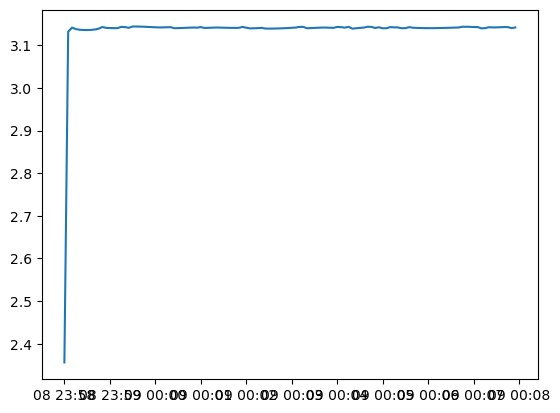

In [27]:
plt.plot(time0 + sol.t * np.timedelta64(1, "s"), sol.y[2, :])

In [28]:
theta_mean = np.mean(sol.y[2, sol.t > (sol.t[-1] - 5)])  # mean for the last few seconds
phi_mean = np.mean(sol.y[3, sol.t > (sol.t[-1] - 5)])

print(round(np.degrees(theta_mean), 3))  # theta
print(round(np.degrees(phi_mean), 3))  # phi

180.007
16180.204
